In [1]:
import os
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. LOAD AND PREPROCESS DATA

# Define folder path
base_folder = "./IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"


# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube

# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))

# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

R = (reference_cube - dark_cube) / denominator
reference = np.clip(R, 0, 1)

# Load and compute reflectance for each sample
reflectance_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    reflectance_cubes[folder] =  np.clip(R, 0, 1)  # Shape: (bands, height, width)

def normalize(ref): # do we need?
    return (ref - np.min(ref)) / (np.max(ref) - np.min(ref))

In [3]:
reference_cube.shape

(26, 1040, 1392)

In [ ]:
# TODO

# S: shape (26,) - your spectral data
# cmfs: shape (26, 3) - columns are x̄, ȳ, z̄
# illuminant: shape (26,) - D65 values at each wavelength

"""S = reference_cube
cmfs = # standar color matching fucntions cie 1931
illuminant = # d65
# TODO align wavelengths of the cmfs and d65

k = 100 / np.sum(cmfs[:, 1] * illuminant)  # normalize using ȳ
X = k * np.sum(S * cmfs[:, 0] * illuminant)
Y = k * np.sum(S * cmfs[:, 1] * illuminant)
Z = k * np.sum(S * cmfs[:, 2] * illuminant)

XYZ = np.array([X, Y, Z])"""


In [11]:
from sklearn.decomposition import PCA
from scipy.ndimage import binary_fill_holes
class lense_image():
    def __init__(self, spectral_cube, wavelengths):
        self.reflectances = spectral_cube
        data = spectral_cube[[wavelengths.index(650), wavelengths.index(550), wavelengths.index(470)], :, :]
        self.BGR = np.moveaxis(data, 0, -1) 
        bgr_8bit = (np.clip(self.BGR, 0, 1) * 255).astype(np.uint8)
        self.Lab = cv2.cvtColor(bgr_8bit, cv2.COLOR_BGR2LAB)

    def sharpen_image(self):
        # Define sharpening kernel
        kernel = np.array([
            [-1, -1, -1],
            [-1,  9, -1],
            [-1, -1, -1]
        ])

        # Apply the kernel to the image
        sharpened = cv2.filter2D(self.BGR, -1, kernel)

        # Save or show result
        plt.imshow(sharpened[225:370,130:300])
        plt.show()
        self.bgr_s = sharpened


    def find_circle(self):
        mask = self.IC_mask[225:370,80:300]
        new_ma = []
        for ma in mask:
            new_ma.append([1 if i else 0 for i in ma])
        new_ma = np.array(new_ma)
        binary_uint8 = (new_ma * 255).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Take the largest contour (the circle)
        c = max(contours, key=cv2.contourArea)

        # Fit a circle
        (x, y), radius = cv2.minEnclosingCircle(c)
        radius = 54 #round(radius)
        center = (round(x), round(y))
        self.center = center
        self.radius = radius

        # Optional visualization
        output = cv2.cvtColor(binary_uint8, cv2.COLOR_GRAY2BGR)
        output = self.BGR[225:370,80:300,:].copy()
        cv2.circle(output, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        cv2.circle(output, (int(x), int(y)), 2, (0, 0, 255), -1)

        # plt.imshow(output)
        # plt.axis('off')
        # #plt.title("Detected Circle")
        # plt.show()
        self.output = output

        mask = np.zeros_like(new_ma, dtype=np.uint8)
        cv2.circle(mask, center, radius, 1, -1) 
        self.mask2 = mask


        r = radius
        x = center[0]
        y = center[1]

        # Crop the image
        im_bgr = self.BGR[225:370,80:300,]
        im_lab = self.Lab[225:370,80:300, :]
        cropped_bgr = im_bgr[y-r:y+r, x-r:x+r, :]
        cropped_lab = im_lab[y-r:y+r, x-r:x+r, :]
        self.mask_c = self.mask2[y-r:y+r, x-r:x+r]

 
        self.IC_bgr = cropped_bgr * self.mask_c[:, :, None]
        self.IC_lab = cropped_lab * self.mask_c[:, :, None]
     

    def align_images_affine(self, img_ref, feature_detector='ORB', max_features=5000, good_match_percent=0.15):

        img_to_align = self.reflectances[wavelengths.index(450)]
        img_ref_8u = (img_ref * 255).astype(np.uint8)
        img_align_8u = (img_to_align * 255).astype(np.uint8)

        # Feature detector
        if feature_detector.upper() == 'SIFT':
            detector = cv2.SIFT_create(max_features)
        elif feature_detector.upper() == 'BRISK':
            detector = cv2.BRISK_create()
        else:
            detector = cv2.ORB_create(max_features)

        # Detect and compute features
        kp1, des1 = detector.detectAndCompute(img_ref_8u, None)
        kp2, des2 = detector.detectAndCompute(img_align_8u, None)

        # Matcher
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING if feature_detector.upper() == 'ORB' else cv2.NORM_L2)
        matches = matcher.match(des1, des2, None)

        # Sort matches by descriptor distance
        matches = sorted(matches, key=lambda x: x.distance)
        num_good_matches = int(len(matches) * good_match_percent)
        matches = matches[:num_good_matches]


        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
        M, inliers = cv2.estimateAffinePartial2D(pts2, pts1, method=cv2.RANSAC, ransacReprojThreshold=3)

        # Keep only inlier matches
        inlier_matches = [m for m, keep in zip(matches, inliers.ravel()) if keep]
        
        matches = inlier_matches

        # Draw matches for visualization
        matches_img = cv2.drawMatches(
            img_ref_8u, kp1, img_align_8u, kp2, matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Display with matplotlib
        plt.figure(figsize=(12, 6))
        plt.imshow(matches_img[..., ::-1])  # Convert BGR → RGB for plotting
        plt.title(f"ORB Matches ({len(matches)} good out of {len(matches)} total)")
        plt.axis("off")
        plt.show()
        # Extract matched points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        # Estimate affine transformation using RANSAC
        M, inliers = cv2.estimateAffinePartial2D(pts2, pts1, method=cv2.RANSAC)

        # Apply affine warp
        height, width = img_ref.shape
        aligned = cv2.warpAffine(img_to_align, M, (width, height))

        return aligned, M
        


    def compute_IC_mask(self):
        spectra = self.BGR.copy()
        height, width, bands = spectra.shape
        pixels = spectra.reshape(-1, bands)
        pixels /= np.linalg.norm(pixels, axis=1, keepdims=True) + 1e-6

        # Apply k means clustering
        k_means = KMeans(n_clusters=5, random_state=0, n_init=10)
        labels = k_means.fit_predict(pixels)

        # Reshape labels to image shape
        segmented_image = labels.reshape(height, width)
        self.segmented_im = segmented_image
       
        # Extract mask for IC region
        pixel_IC = (300,190) # TODO algorithm instead of manually
        IC_label = segmented_image[pixel_IC]
        mask = (segmented_image == IC_label).astype(int)

        # Flood filly from circle to keep only connected region
        flood_mask = mask.copy()
        cv2.floodFill(flood_mask, None, (pixel_IC[1], pixel_IC[0]), 128)  # TODO
        circle_mask = np.uint8(flood_mask == 128)


        # Morphological closing to close small gaps and fill any internal holes
        #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        #closed = cv2.morphologyEx(circle_mask, cv2.MORPH_CLOSE, kernel)
        #filled = binary_fill_holes(closed > 0)

        self.IC_mask = circle_mask#[None, :, :]  # shape: (1, H, W)
        self.n_pixels = np.count_nonzero(circle_mask == 1)

        #print(f"Number of pixels in the circle: {self.n_pixels}")

        """plt.imshow(circle_mask, cmap='gray')
        plt.axis('off')
        plt.title('IC region')
        plt.show()"""

        
    def CTQs(self, ref_mask):
     
        masked_pixels = self.BGR[:, ref_mask != 0]  # shape -> (3, N)

        mean_val = np.array([
            masked_pixels[c].mean() 
            for c in range(masked_pixels.shape[0])
        ])
        std_val = np.array([
            masked_pixels[c].std() 
            for c in range(masked_pixels.shape[0])
        ])
        self.IC_mean = mean_val
        self.IC_std = std_val
        
    def compare_ref(self, reference, ref_lab):
        error = 0
        min_val = 100
        max_val = 0
        c=0
        for row1, row2 in zip(self.IC_bgr, reference):
            for pixel1, pixel2 in zip(row1, row2):
                if pixel2.all() != 0:
                    err = np.linalg.norm(pixel1 - pixel2)
                    error += err
                    c+=1
                    if err > max_val: max_val = err
                    elif err < min_val: min_val = err
        self.max_error = max_val
        self.min_error = min_val
        self.mean_error = error/c

        error = 0
        min_val = 100
        max_val = 0
        c=0
        for row1, row2 in zip(self.IC_lab, ref_lab):
            for pixel1, pixel2 in zip(row1, row2):
                if pixel2.all() != 0:
                    err = np.linalg.norm(pixel1 - pixel2)
                    error += err
                    c+=1
                    if err > max_val: max_val = err
                    elif err < min_val: min_val = err
        self.max_error_lab = max_val
        self.min_error_lab = min_val
        self.mean_error_lab = error/c
    
    def compute_mean(self):
        error = 0
        min_val = 100
        max_val = 0
        c=0
        mean_nonzero = []
        for c in range(self.IC_bgr.shape[2]):
            A = self.IC_bgr[:,:,c]
            mean_nonzero.append(A[A != 0].mean())
        self.mean_color = mean_nonzero

        mean_nonzero = []
        for c in range(self.IC_lab.shape[2]):
            A = self.IC_lab[:,:,c]
            mean_nonzero.append(A[A != 0].mean())
        self.mean_color_lab = mean_nonzero


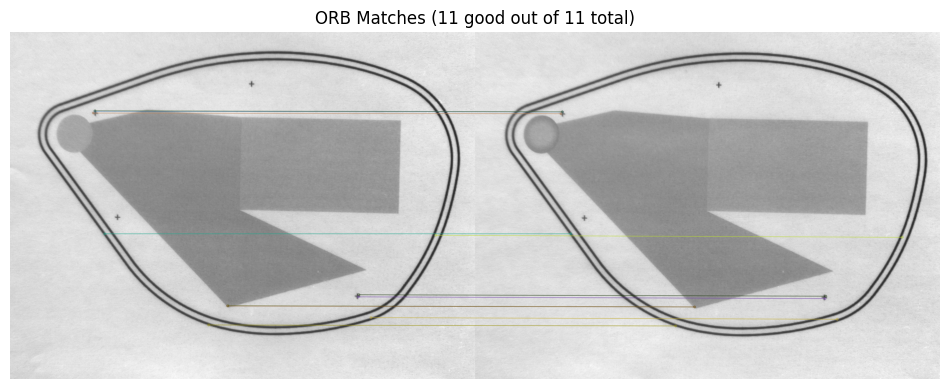

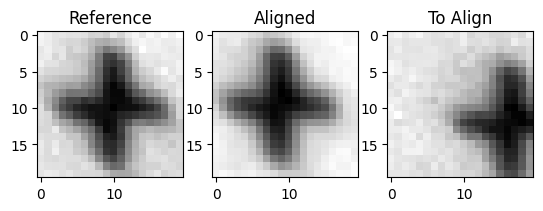

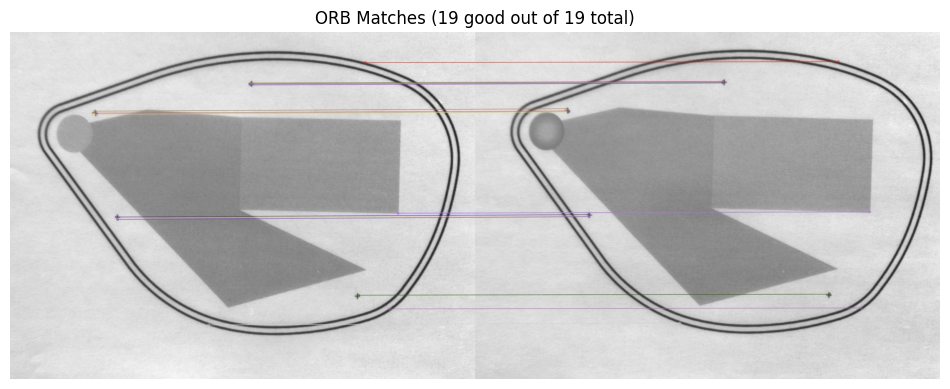

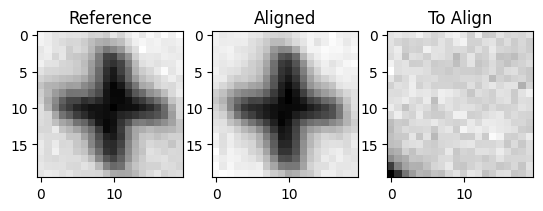

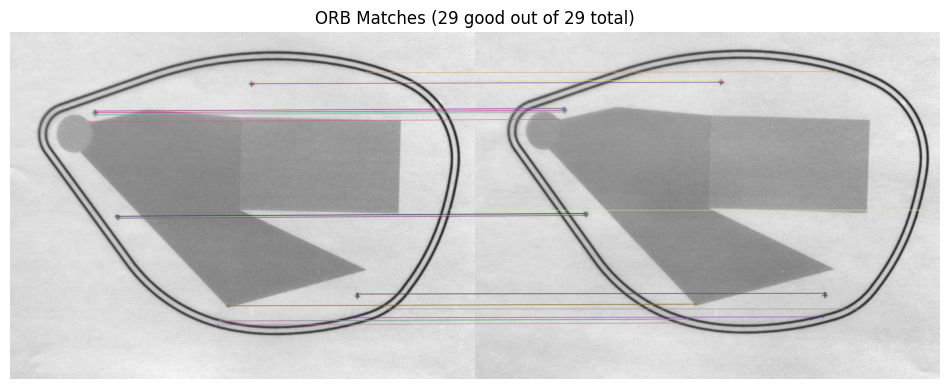

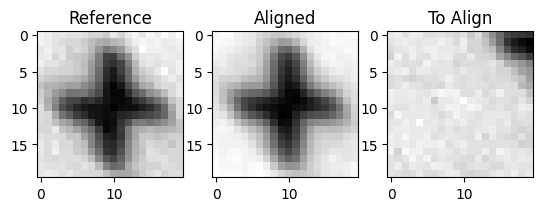

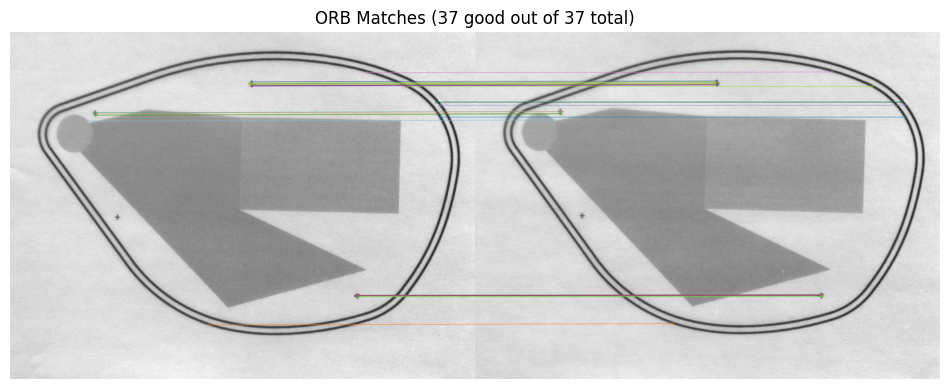

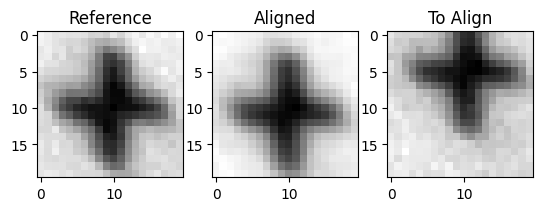

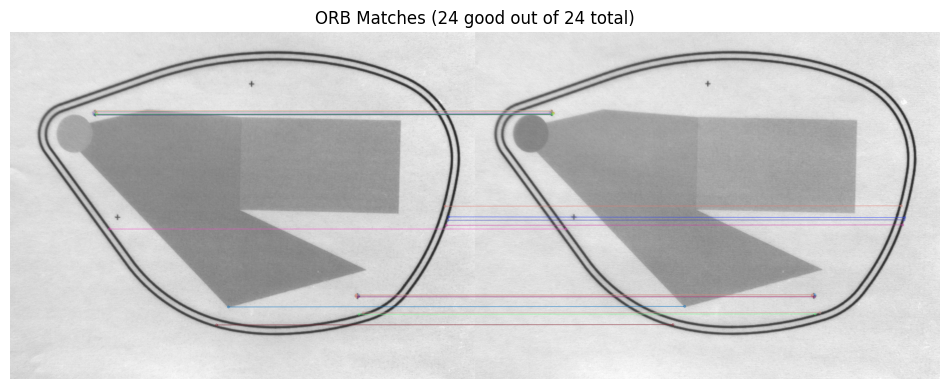

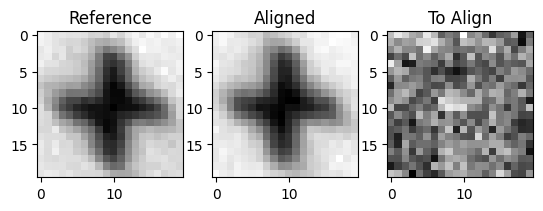

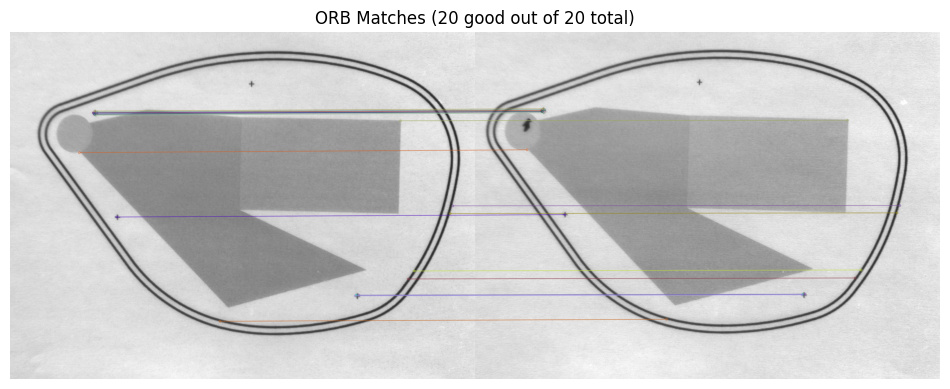

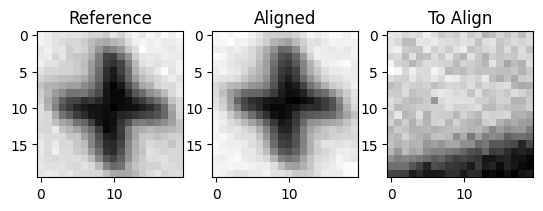

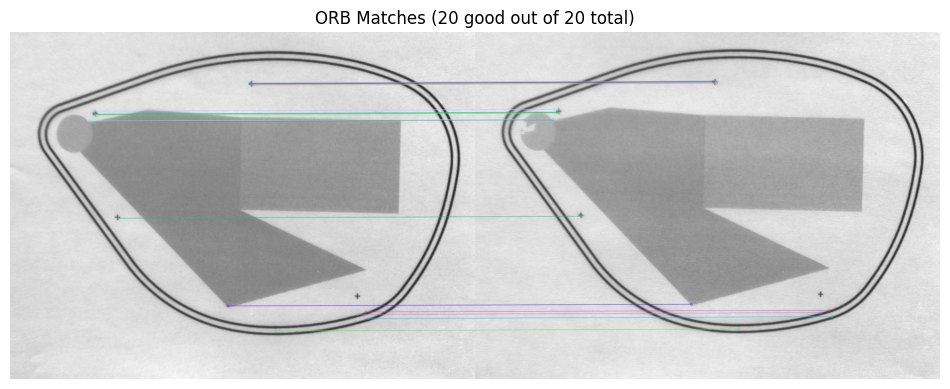

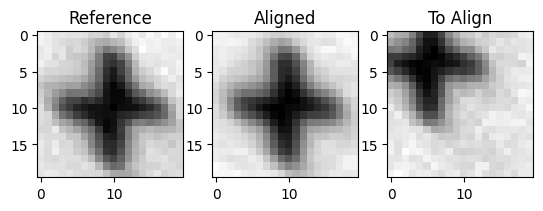

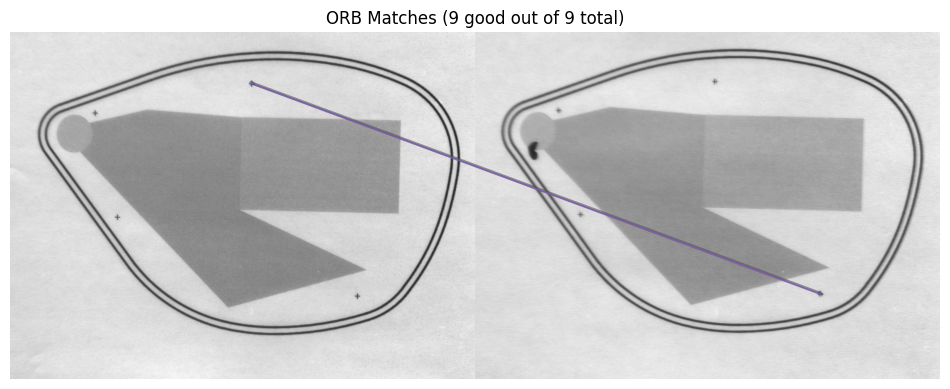

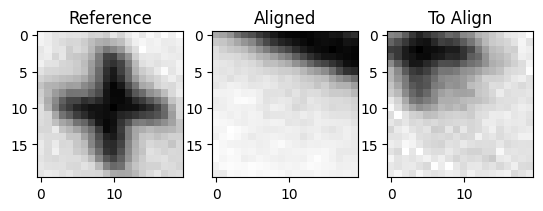

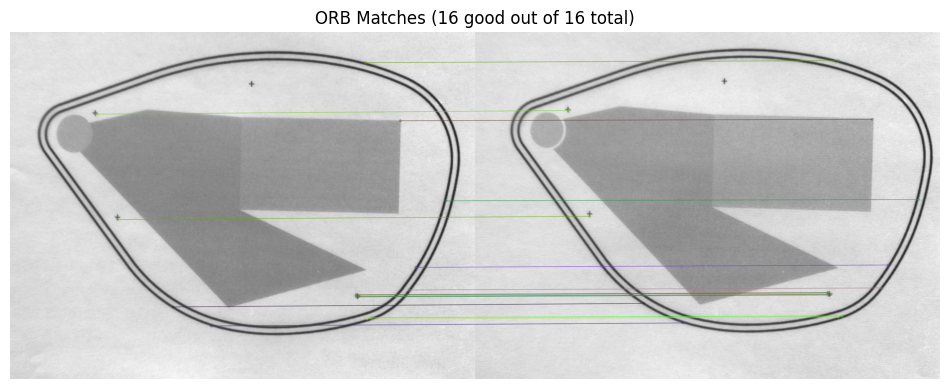

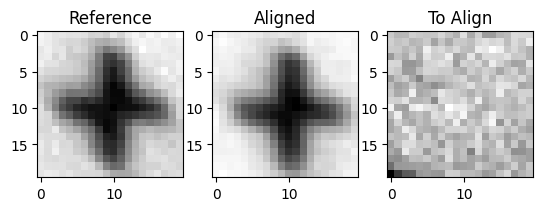

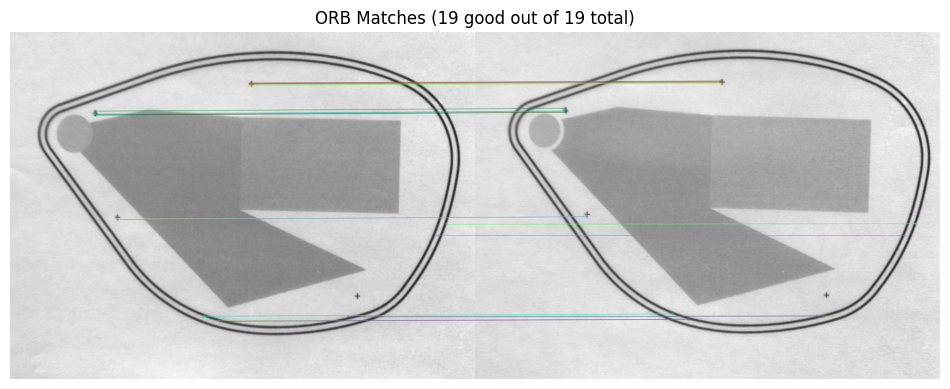

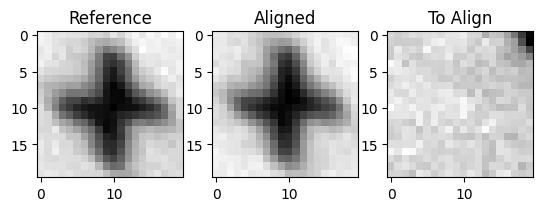

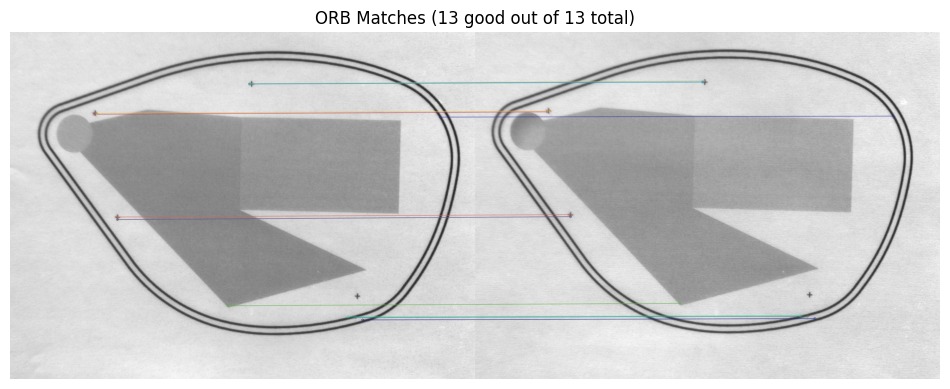

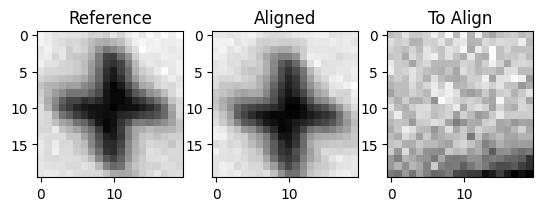

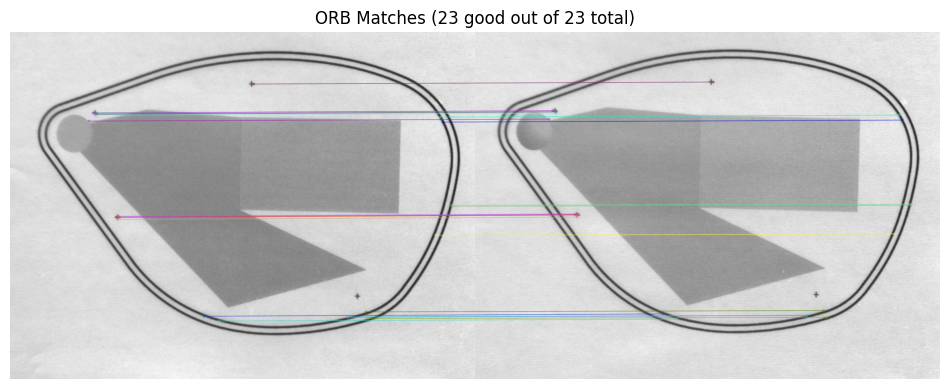

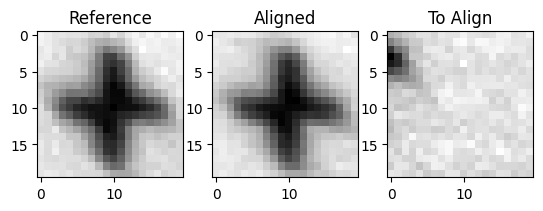

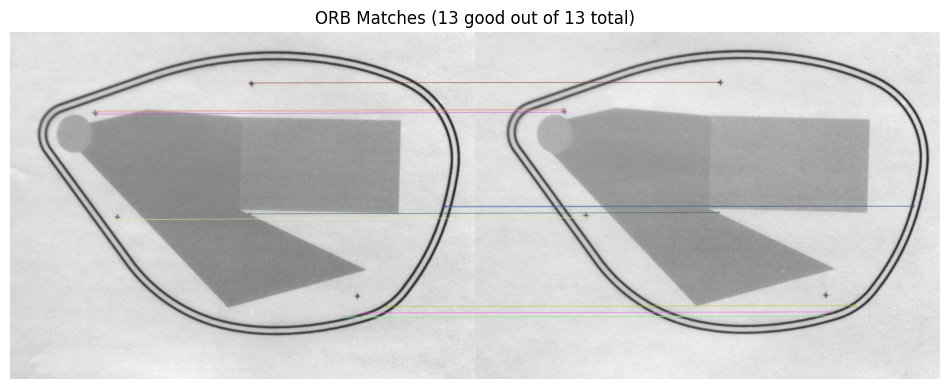

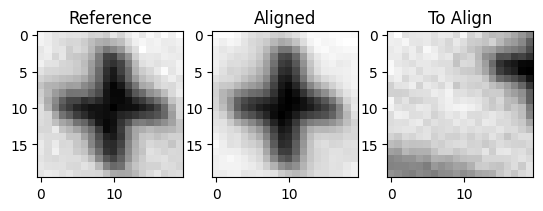

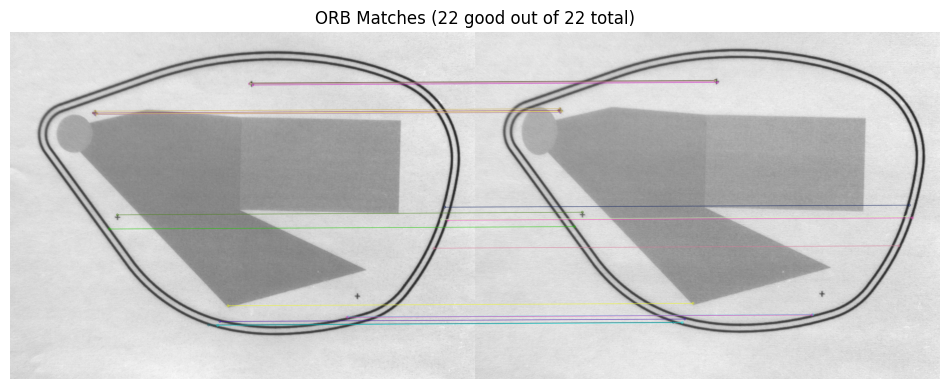

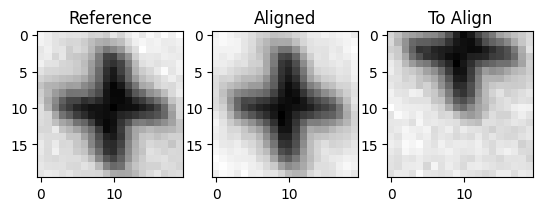

In [19]:
# 2. Compute CTQs for reference
outputs = []
out2 = []
errors = []
out3 = []
rgbs = []
labs = []
reference_lense = lense_image(reference, wavelengths)
reference_lense.compute_IC_mask()
reference_lense.find_circle()
reference_lense.compute_mean()
outputs.append(reference_lense.output)
out2.append(reference_lense.IC_bgr)
out3.append(reference_lense.BGR[225:370,80:300])

img_ref = reference[wavelengths.index(450)]
for folder in sample_folders:
    lense = lense_image(reflectance_cubes[folder], wavelengths)
    lense.compute_IC_mask()
    lense.find_circle()
    lense.compute_mean()
    outputs.append(lense.output)
    out2.append(lense.IC_bgr)
    out3.append(lense.BGR[225:370,80:300])
    lense.compare_ref(reference_lense.IC_bgr, reference_lense.IC_lab)
    errors.append([lense.mean_error, lense.min_error, lense.max_error, lense.mean_error_lab, lense.min_error_lab, lense.max_error_lab])
    rgbs.append(lense.mean_color)
    labs.append(lense.mean_color_lab)
    
    aligned, H = lense.align_images_affine(img_ref, feature_detector='ORB')
    # Visualization
    plt.subplot(1, 3, 1)
    plt.title("Reference")
    plt.imshow(img_ref[235:255,245:265], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Aligned")
    plt.imshow(aligned[235:255,245:265], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("To Align")
    plt.imshow(lense.reflectances[wavelengths.index(450),235:255,245:265], cmap="gray")
    plt.show()

In [20]:
r = reference_lense.mean_color[0]
g = reference_lense.mean_color[1]
b  = reference_lense.mean_color[2]

for m in rgbs:
    print(((m[0]-r)**2+(m[1]-g)**2+(m[2]-b)**2)**(1/2))

0.07731720492178615
0.13984828064226648
0.11464030207048251
0.02135559207671523
0.20417602388813444
0.028204439907309944
0.1164720279639019
0.04320936986321277
0.10305613484860558
0.1451405433645738
0.05347469121172937
0.06297021926905254
0.06899568156004733
0.05940252381683028


In [21]:
r = reference_lense.mean_color_lab[0]
g = reference_lense.mean_color_lab[1]
b  = reference_lense.mean_color_lab[2]

for m in labs:
    print(((m[0]-r)**2+(m[1]-g)**2+(m[2]-b)**2)**(1/2))

10.744866680760705
19.585256683761198
18.864678068119378
5.001566955416426
28.670962609770193
3.4834804361919636
15.288322649124906
5.082255885662385
13.467587875740241
19.120710800691295
8.052245207092529
9.258949465385374
8.693566332997491
7.357005951148402


In [8]:
for i in errors:
    print(i[0], i[1], i[2], i[3], i[4], i[5])

0.09449468956942539 0.0027957308275550707 0.2842655018903693 287.03510911085067 0.0 441.6729559300637
0.1494471457294469 0.00288573041012343 0.3535106109971005 330.59143181508136 1.0 441.6729559300637
0.11972768610719545 0.02394797723923459 0.1891948255309454 304.422963878718 100 439.36658953543565
0.04026009009600133 0.0020073104636127745 0.13343565434713398 312.6935636465054 0.0 441.6729559300637
0.20588827705802767 0.01023318956363764 0.2986821221130945 311.8647991641434 100 440.5190120755289
0.11311478879559841 0.00625211813545047 0.8409938323538702 286.0905218419559 0.0 441.6729559300637
0.12226939202728834 0.0032521554836652906 0.5780280224864376 280.95798366296157 1.0 441.6729559300637
0.13263071843579596 0.00298248146146412 0.8663868525818609 291.0259300371855 0.0 441.6729559300637
0.1093172422421572 0.001416071038136804 0.5604226595716418 274.2083369336709 1.0 441.6729559300637
0.1502124499710342 0.00445493056008779 0.5966639518205976 287.8858068766322 1.4142135623730951 441.0

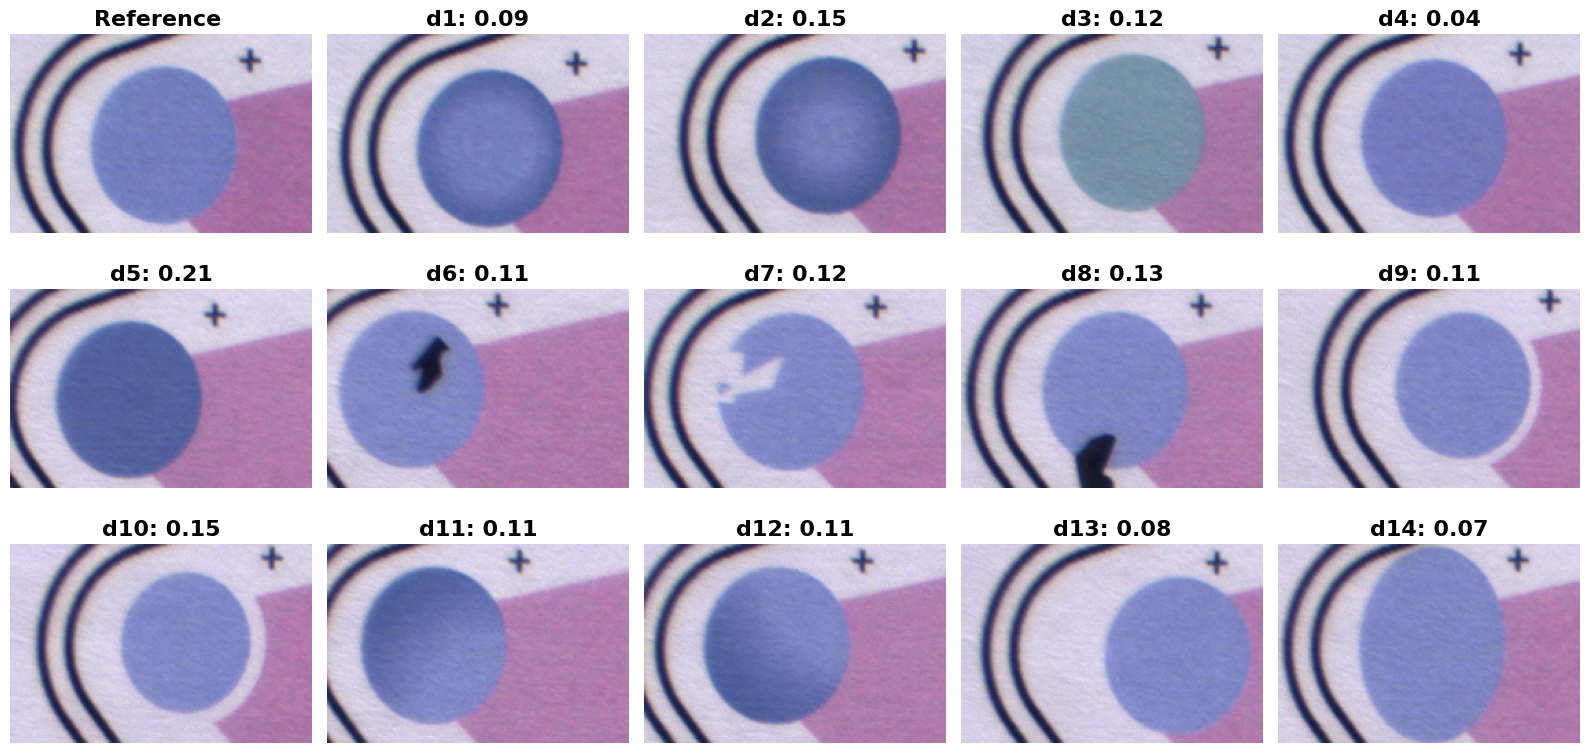

In [9]:
# Plot reference and all defects
ecs = []
ecs.append(' ')
for i in errors:
    ecs.append(np.round(i[0],2))
imss = out3
titles = ['Reference'] + [f'd{i}: ' for i in range(1, 15)]  # ['ref', 'd1', 'd2', ..., 'd13']
rows, cols = 3,5
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    if i < len(imss):
        ax.imshow(imss[i])
        ax.set_title(titles[i]+str(ecs[i]), fontsize=16, fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
